In [1]:
# Pacotes essenciais
import pandas as pd
import numpy as np
import math
import datetime

import  matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from scipy.stats import kurtosis

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report

# pre-processing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
#models
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam




from imblearn.over_sampling import SMOTE


# Tunning hiperparameters
from sklearn.pipeline import Pipeline
import optuna


#optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [4]:
print(tf.__version__)

2.13.0


# **Introdução**

Um problema persistente na área da manutenção é a identificação e redução de falhas nos equipamentos em serviço. Uma das técnicas mais utilizadas para a redução de falhas em equipamentos é a aplicação da manutenção preditiva, onde é realizado o acompanhamento, monitoramento e inspeção de máquinas com o objetivo de coletar dados que informam o desgaste dos equipamentos e seu processo natural de degradação. Assim, com esses dados, é possível realizar manutenções em períodos anteriores a falha, aumentando a vida útil do equipamento.

Porém, como definir qual é o momento ideal para realizar a parada do equipamento?

Visando definir este tempo ideal, será desenvolvido um algoritmo de machine learning capaz de prever com antecedência quando ocorrerá a falha do equipamento, sendo possível executar a manutenção preditiva com maior eficiência.

Para a avaliação do modelo será utilizado a métrica Recall, visando assim penalizar mais os erros de falsos negativos para que não ocorra falhas indesejadas.


Para a elaboração deste projeto será realizado as seguintes etapas:
- Introdução: Visando esclarecer o objetivo do projeto, as métricas e as etapas a serem realizadas no desenvolvimento do modelo de machine learning.

- Limpeza dos dados e pré-processamento: Será feito uma pré-visualização dos dados, visando identificar e tratar dados ausentes, verificar quantas variáveis existem e o tipo de cada uma, além da criação de features simples com base nas features iniciais.

- Análise Exploratória dos Dados (EDA): Será realizado visualizações com o objetivo encontrar insights relevantes para o desenvolvimento do algoritmo, juntamente realizando o tratamento de algumas features com base em insights levantados.

- Correlação e processamento final: Será analisado a correlação entre os dados visando evitar possíveis problemas de multicolinearidade, realizando a remoção das variáveis indesejáveis.

- Seleção e Implementação de modelo: É a etapa onde será elaborado o modelo de machine learning para a solução do problema. Nesta etapa também será realizado o tunning de hiperparâmetros do modelo, visando melhorar o resultado obtido inicialmente.

- Conclusão: Etapa onde será realizado comentários em relação ao projeto realizado e também alguns levantamentos de melhorias futuras.

# **Limpeza dos dados e pré-processamento**  

In [5]:
data = pd.read_csv('predictive_maintenance_dataset.csv')
data.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric7  124494 non-null  int64 
 10  metric8  124494 non-null  int64 
 11  metric9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


No dataset tem-se o total de 11 variáveis, excluindo a variável target, sendo composto por 9 sensores em formato numérico, uma variável data em formato ‘object’ necessitando conversão para ‘datetime’, e uma variável ‘device’ em formato categórico.

In [7]:
data.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.492706,9.940897,1.741120,14.222669,260172.657726,0.292528,0.292528,13.013848
std,0.029167,7.045933e+07,2179.677781,185.748131,22.908507,15.943028,99151.078547,7.436924,7.436924,275.661220
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,70000.000000


Observa-se que as variáveis 'metric1', 'metric5' e 'metric6' são as variáveis que possuem uma oscilação de valores.

As variáveis 'metric2', 'metric3', 'metric4', 'metric7', 'metric8' e 'metric9' possuem uma maior presença de valores iguais à 0 e alguns valores máximos elevados que podem estar relacionados com a presença de falhas.


In [8]:
 data['date'] = pd.to_datetime(data['date']) 

In [9]:
data['date'].describe()

C:\Users\Pichau\AppData\Local\Temp\ipykernel_12080\2382045578.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['date'].describe()


count                  124494
unique                    304
top       2015-01-01 00:00:00
freq                     1163
first     2015-01-01 00:00:00
last      2015-11-02 00:00:00
Name: date, dtype: object

Após a conversão da variável ‘date’ nota-se que os dados são coletados diariamente e englobam datas entre o dia 01/01/15 até 02/11/15.

In [10]:
data.nunique()

date          304
device       1169
failure         2
metric1    123877
metric2       560
metric3        48
metric4       115
metric5        60
metric6     44838
metric7        28
metric8        28
metric9        67
dtype: int64

Analisando a tabela, vemos que no dataset temos 1169 categorias  diferentes em 'device'. 

Nota-se que as 'metric' 2, 3, 4, 5, 7, 8 e 9 possuem pouca oscilações de valores medidos.

In [11]:
data.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [12]:
data.duplicated().sum()

1

Nota-se inicialmente que não existe dados ausentes em nenhuma variável e somente 1 linha duplicada. Baseado nisso será feito a remoção desta linha duplicada.

In [13]:
data.drop_duplicates(inplace = True)

Como manipulação inicial será realizado a criação de variáveis auxiliares para data, separando o dia, mês, ano, dia da semana e semana do mês. Também será realizado a separação da variável 'devices' em dois, sendo uma relacionada aos quatro primeiros valores da string, que indica o setor onde o equipamento está instalado, e a segunda feature relacionada aos outros caracteres da string, indicando o tipo de equipamento.

O correto para fazer a divisão da TAG do 'device' é saber o padrão da empresa trabalhada, para assim poder identificar corretamente o setor, qual equipamento está sendo abordado e o identificador único do equipamento. Como não temos o acesso a esta informação será feito a divisão simplificada inicialmente citada.


In [14]:
def extra_features(data):
    # datetime features
    df = data.copy()
    df['day']       = df['date'].dt.day
    df['month']     = df['date'].dt.month
    df['year']      = df['date'].dt.year
    df['day_week']  = df['date'].dt.weekday
    df['weekmonth'] = (df['day'] - 1) // 7 + 1
    
    # devices features
    df['sector']     = df['device'].str[:4]
    df['equipment']  = df['device'].str[4:]
    return df

In [15]:
df = extra_features(data)

In [16]:
df.nunique()

date            304
device         1169
failure           2
metric1      123877
metric2         560
metric3          48
metric4         115
metric5          60
metric6       44838
metric7          28
metric8          28
metric9          67
day              31
month            11
year              1
day_week          7
weekmonth         5
sector            7
equipment      1169
dtype: int64

Nota-se que subdividindo a variável 'device' encontramos que ela opera em 7 setores diferentes e com 1169 de equipamentos diferentes, igual a quantidade de devices inicialmente observada.

# **Análise Exploratória dos Dados (EDA)**

# Avaliando a distribuição de falhas

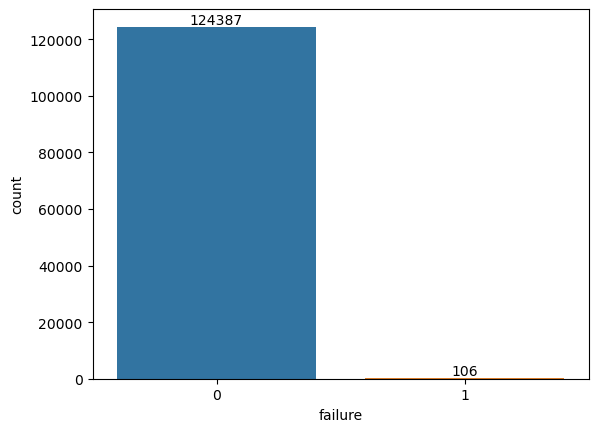

In [17]:
ax = sns.countplot(data = df,x = 'failure')
ax.bar_label(ax.containers[0])
plt.show()

Nota-se pelo gráfico uma proporção de dados normais muito maior do que os dados de falha, tendo somente 106 dispositivos que apresentaram falha. 

Posteriormente será realizado uma operação visando balancear essas classes desta variável objetivo.

Como poucos equipamentos sofreram falhas, talvez eles tenham sido substituídos ou trocados por outro equipamento ao longo do tempo, portanto será feito uma verificação da quantidade de 'devices' ao longo do tempo neste dataset e se os dispositivos que apresentaram falha estão presentes no dataset desde o início.


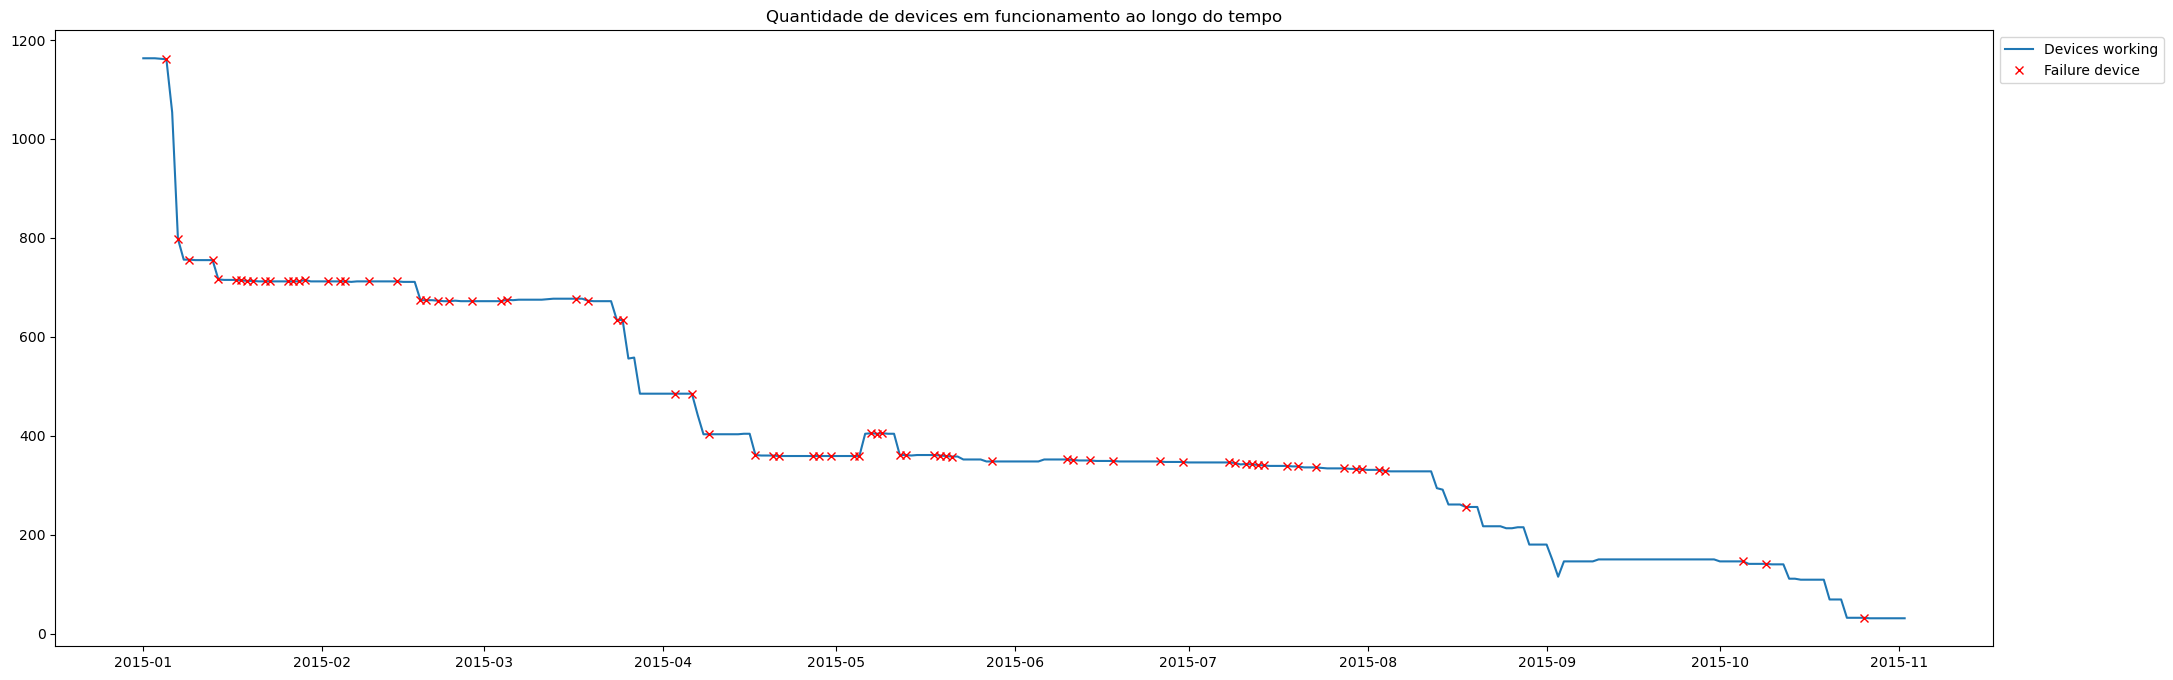

In [18]:
df_group = df.groupby('date').agg(count_devices = ('device','count'), failure = ('failure','max'))
fig, ax = plt.subplots(figsize=(25,8))
plt.plot(df_group.index,df_group['count_devices'], label = 'Devices working')

idx = df_group[df_group['failure'] == 1]
plt.plot(idx.index, idx['count_devices'], 'rx',label = 'Failure device')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.title('Quantidade de devices em funcionamento ao longo do tempo')
plt.show()

Nota-se que ocorreu uma queda expressiva dos equipamentos em funcionamento com o passar dos meses, principalmente do mês de janeiro para fevereiro. 

Observando os dias em que ocorreram falhas nos dispositivos, nota-se que esses dias não acarretam na diminuição dos equipamentos em funcionamento.

Também é possível observar que só houve aumento de quantidade significativa de dispositivos em dois períodos, no começo do mês de maio e no começo do mês de setembro.

Como a quantidade de dispositivos apresentado no início do mês de janeiro é igual a quantidade de dispositivos apresentados no dataset não foram adicionados novos equipamentos com o passar do tempo, mas pode ter ocorrido a parada de funcionamento desses equipamentos ou estabelecido uma rotatividade de funcionamento entre os dispositivos.


# Observação

**Como as métricas são coletadas diariamente será considerado que as métricas coletadas para cada dispositivo foram coletadas ao mesmo tempo do mesmo dia.**

Como não é informado em que momento a métrica foi colhida, seja no dia em que aconteceu a falha, um dia anterior a falha, seja com as métricas coletadas com o equipamento operando na iminência da falha ou em qualquer outra situação que possa ser decisiva para a construção do modelo de previsão, será suposto que **'a falha ocorrerá no dia posterior a medição realizada’**.

Com essas considerações o modelo a ser planejado e construído será com base neste um dia de antecedência, para que assim possa ser feito a parada e a manutenção do equipamento com pelo menos um dia de antecedência a falha.




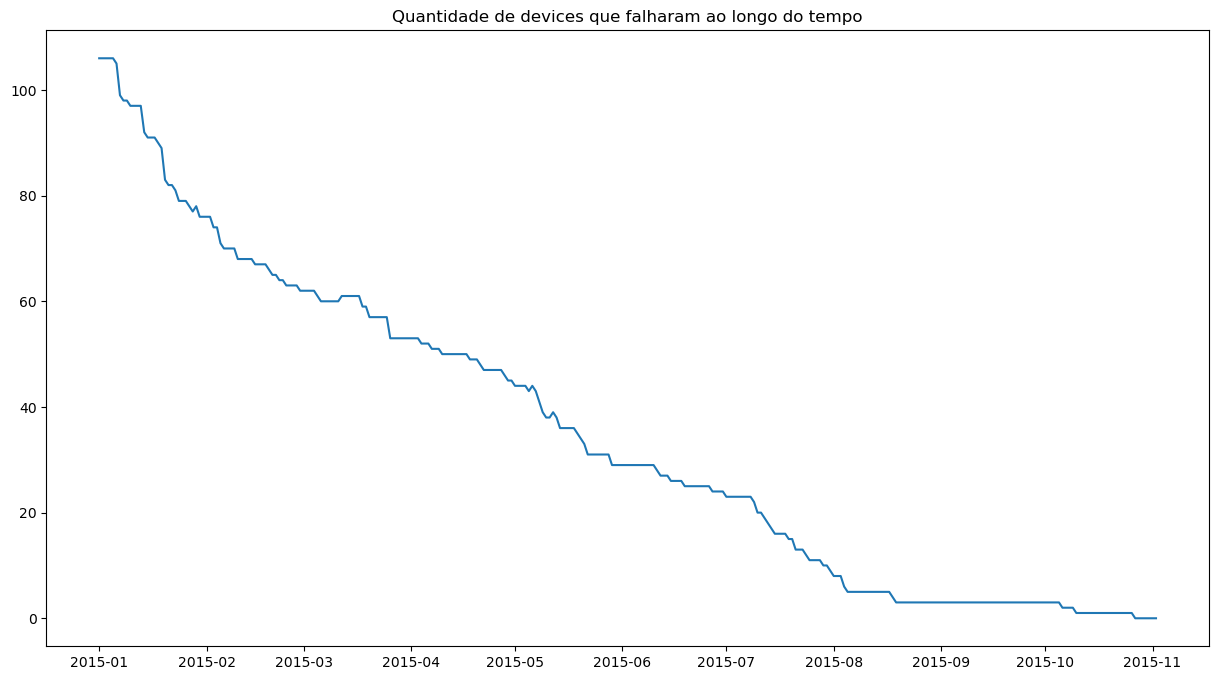

In [19]:
fail_list = df[df['failure'] == 1].device.unique()
aux = df.copy()
aux['fail_dev'] = aux['device'].agg(lambda x: 1 if x in fail_list else 0)

df_group = aux.groupby('date').agg(failure_devices = ('fail_dev', lambda x: np.sum(x>0)))
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(df_group.index,df_group['failure_devices'])
plt.title('Quantidade de devices que falharam ao longo do tempo')
plt.show()

Nota-se pelo gráfico que não foram todos os equipamentos que tiveram falha que operaram durante o ano inteiro, tendo o mesmo perfil de diminuição de operação com o passar do tempo que o gráfico anterior.

É possível observar que ocorrem oscilações neste grupo de equipamentos em funcionamento, portanto neste caso é possível inferir que pode ocorrer uma alternância de funcionamento dos equipamentos ao longo dos meses, visto que o equipamento quando falha ou ele é substituído ou é realizado a sua manutenção e colocado em operação novamente.

Como existe esta alternância de funcionamento será criado uma variável para contabilizar a quantidade de dias trabalhado por cada dispositivo e uma outra variável para contabilizar quantas vezes o equipamento foi religado.


In [20]:
df['op_period'] = 0
df['dev_reconnected'] = 0
device_list = df['device'].unique()
for x in device_list:
    idx = df['device'] == x # pegamos todos os indexs onde um 'y' device está presente    
    aux = np.sum(idx)
    aux2 = range(1,aux+1)
    df.loc[idx,'op_period'] = aux2
    
    idx2 = df[idx].index
    for i in range(0,len(idx2)-1):
        aux = (df.loc[idx2[i],'date'])+datetime.timedelta(days=1)
        aux2 =(df.loc[idx2[i+1],'date'])
        if aux != aux2:
            df.loc[idx2[i+1],'dev_reconnected'] = df.loc[idx2[i],'dev_reconnected']+1
        else:
            df.loc[idx2[i+1],'dev_reconnected'] = df.loc[idx2[i],'dev_reconnected']

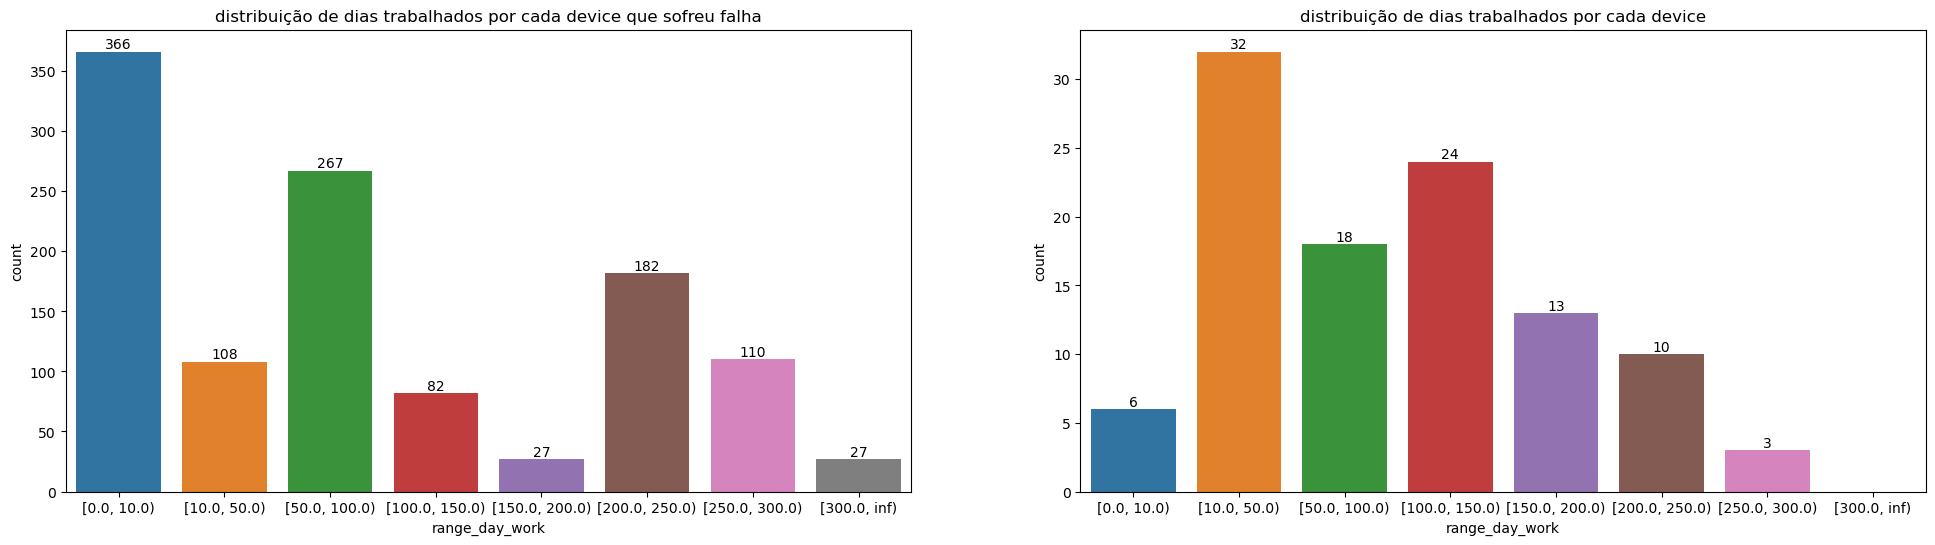

In [21]:
df_group = df.groupby('device').agg(days_work = ('op_period','max'))
lst_ranges = [(0, 10), (10, 50), (50, 100),(100, 150), (150, 200), (200,250),(250,300), (300, np.infty)]
ranges = pd.IntervalIndex.from_tuples(lst_ranges, closed = 'left')

df_group['range_day_work'] = pd.cut(df_group['days_work'], bins=ranges)

df_group2 = df[df['failure'] == 1].groupby('device').agg(days_work = ('op_period','max'))
df_group2['range_day_work'] = pd.cut(df_group2['days_work'], bins=ranges)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,6))
sns.countplot(data = df_group, x = 'range_day_work', ax = ax1)
ax1.bar_label(ax1.containers[0])
ax1.set_title('distribuição de dias trabalhados por cada device que sofreu falha')

sns.countplot(data = df_group2, x = 'range_day_work', ax = ax2)
ax2.bar_label(ax2.containers[0])
ax2.set_title('distribuição de dias trabalhados por cada device')
plt.show()

Pelo histograma de todo os dispositivos é possível inferir que mais de 350 dispositivos possui menos que 10 dias de trabalho. Além disso, é notável mais duas concentrações, sendo uma delas com tempo de trabalho entre 50 a 100 dias e outro com tempo de trabalho entre 200 e 250 dias.

Aproximadamente 27 dispositivos possuem mais de 300 dias em operação no dataset.

Analisando o histograma com somente os dispositivos que falharam, ocorre duas concentrações, sendo uma delas entre 10 e 50 dias de funcionamento e outra entre 100 e 150 dias.
 

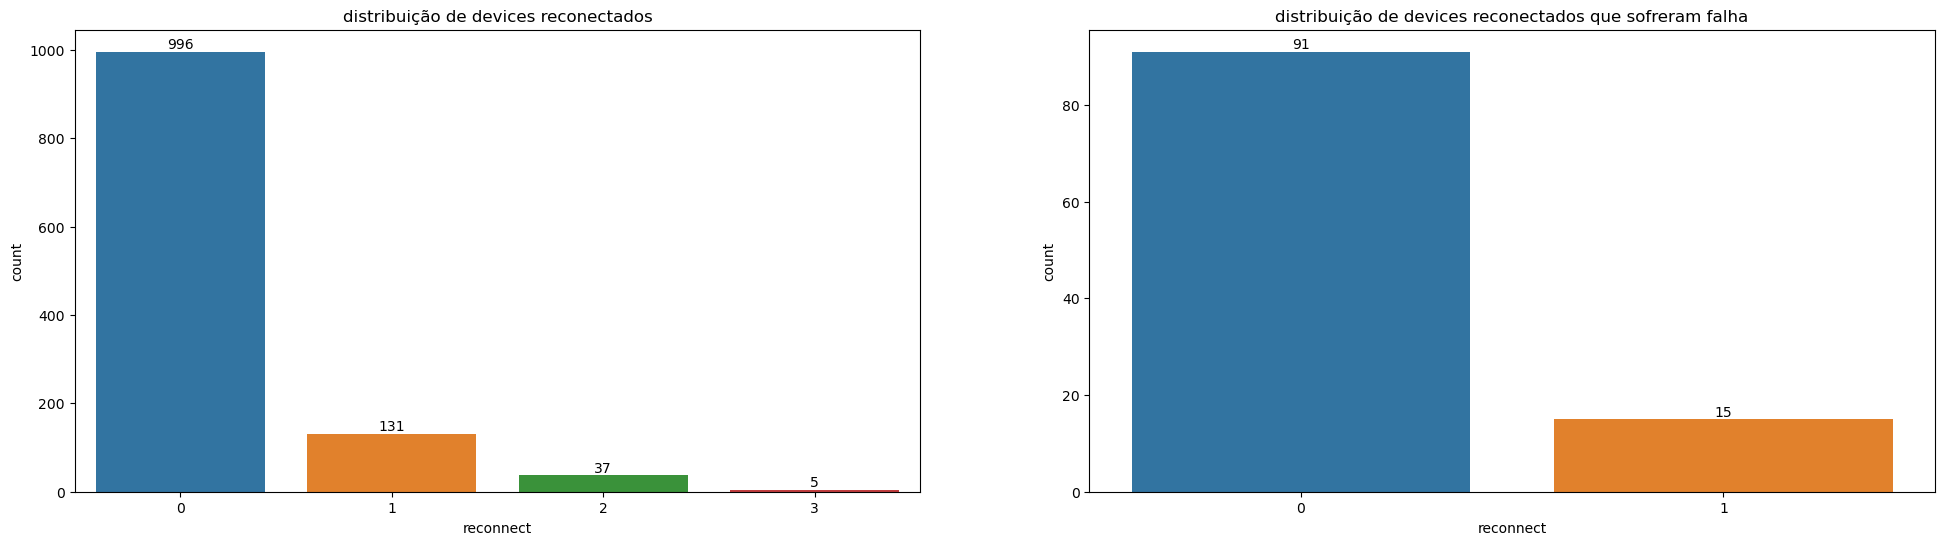

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,6))

df_group = df.groupby('device').agg(reconnect = ('dev_reconnected','max'))

sns.countplot(data = df_group, x = 'reconnect', ax = ax1)
ax1.bar_label(ax1.containers[0])
ax1.set_title('distribuição de devices reconectados')


df_group2 = df[df['failure'] == 1].groupby('device').agg(reconnect = ('dev_reconnected','max'))

sns.countplot(data = df_group2, x = 'reconnect',ax = ax2)
ax2.bar_label(ax2.containers[0])
ax2.set_title('distribuição de devices reconectados que sofreram falha')

plt.show()

Nota-se que a maioria dos equipamentos só foi ligado uma vez e que no máximo 5 equipamentos foram religados até 3 vezes. Isso pode indicar que na maioria dos casos foram feitas substituições dos equipamentos ao invés de um revezamento entre eles.

Analisando somente os equipamentos que apresentaram falha, a maioria só foi ligada uma vez e no máximo religado uma vez, indicando que na maioria dos casos foi feito a substituição dos dispositivos e que em poucos casos ocorreu o reparo do equipamento e o mesmo foi posto para funcionar novamente.


# Avaliando as métricas

In [23]:
df['metric1'].sort_values().head(600).unique()

array([      0,    2048,    2056,    2168,    3784,    4224,    4480,
          4560,    8280,    8616,    9088,    9472,   11480,   12776,
         13824,   15928,   17272,   18800,   19120,   23840,   26624,
         28568,   30088,   35544,   37680,   40208,   41000,   43016,
         43888,   45088,   45216,   47288,   47472,   47528,   48128,
         48152,   48384,   49272,   49792,   50128,   50584,   50696,
         52664,   53184,   54040,   60192,   61208,   72808,   75736,
         76200,   78120,   79240,   89968,   90528,   95216,   96024,
         96264,   96272,   96968,   97848,   98736,  100920,  101640,
        112376,  112760,  123608,  124768,  125456,  127088,  127384,
        132096,  132832,  134568,  142720,  144368,  151600,  152520,
        155968,  156120,  157792,  163912,  167408,  172112,  172696,
        172984,  176912,  177520,  178568,  183192,  183760,  188416,
        192576,  194072,  196064,  198760,  199312,  199672,  200144,
        202056,  207

Na 'metric1' aparentemente todos os valores são divisíveis por 8, mas como a vizualização dos valores únicos não é completa será feito uma verificação da multiplicidade para depois realizar a divisão.

In [24]:
def multi(x,i):
    if x%i == 0:
        return True
    else:
        return False
    
a = df['metric1'].apply(lambda x: multi(x,8))
a[a == False].count()

46

Existem 46 valores que não são múltiplos de 8 para a métrica 1. Tendo a noção que o dataset conta com 124494 dados e somente 46 não são múltiplos 8, provavelmente estes valores foram erros de medição do sinal. Portanto será feito a aproximação desses valores para o múltiplo de 8 acima dele.

In [25]:
df['mnw1'] = df['metric1']/8
df['mnw1'] = df['mnw1'].apply(lambda x: math.ceil(x))

In [26]:
df['metric2'].sort_values().unique()

array([    0,     8,    16,    24,    32,    40,    48,    55,    56,
          64,    72,    80,    88,    96,   104,   112,   120,   128,
         136,   144,   152,   160,   168,   176,   184,   192,   200,
         208,   216,   224,   232,   240,   248,   256,   264,   272,
         280,   288,   296,   304,   320,   328,   336,   344,   352,
         360,   368,   376,   384,   392,   400,   408,   416,   424,
         432,   440,   448,   456,   464,   472,   480,   488,   496,
         504,   512,   520,   528,   536,   544,   552,   560,   568,
         576,   584,   592,   600,   608,   616,   624,   632,   640,
         648,   656,   664,   672,   680,   704,   712,   728,   736,
         744,   752,   760,   776,   792,   800,   808,   816,   824,
         832,   840,   848,   864,   872,   888,   896,   912,   920,
         928,   936,   944,   952,   960,   968,   976,   984,   992,
        1000,  1024,  1032,  1040,  1048,  1056,  1064,  1072,  1080,
        1088,  1096,

Analisando os valores únicos da 'metric2' nota-se que todos são múltiplos de 8, exceto o valor 55. 

In [27]:
df[df['metric2'] == 55].metric2.count()

1

Como só existe este único valor de 55 e todos os outros são múltiplos de 8, ele será modificado para o valor mais próximo, 56, e será feito a divisão dos dados por 8, criando uma nova métrica.

In [28]:
idx = df['metric2'] == 55
df.loc[idx,'metric2'] = 56
df['mnw2'] = df['metric2']/8
df['mnw2'] = df['mnw2'].astype(int)

In [29]:
df['metric3'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     7,     8,     9,
          10,    11,    12,    14,    15,    16,    18,    21,    24,
          25,    34,    35,    36,    38,    53,    56,    61,    62,
          70,    72,   100,   107,   208,   220,   263,   266,   279,
         318,   323,   377,   378,   382,   406,  1162,  1326,  1331,
        2112,  2693, 24929], dtype=int64)

Para 'metric3' não é possível perceber nenhum padrão, porém é visível a presença de alguns valores muito elevados.

In [30]:
df['metric4'].sort_values().unique()

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         34,   35,   36,   37,   38,   39,   40,   41,   43,   44,   45,
         46,   48,   49,   50,   51,   52,   53,   55,   56,   57,   58,
         60,   62,   65,   67,   69,   73,   74,   76,   79,   80,   86,
         90,   91,   94,   95,   97,  100,  108,  112,  118,  121,  122,
        128,  129,  135,  147,  160,  164,  173,  175,  186,  204,  214,
        215,  235,  236,  256,  288,  297,  299,  300,  305,  322,  331,
        399,  400,  401,  405,  406,  431,  486,  487,  521,  529,  533,
        763,  841, 1033, 1074, 1666], dtype=int64)

Para 'metric4' não é possível perceber nenhum padrão.

In [31]:
df['metric5'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       70, 78, 89, 90, 91, 92, 94, 95, 98], dtype=int64)

Para 'metric5' não é possível perceber nenhum padrão entre seus valores.

In [32]:
df['metric6'].sort_values().head(9000).unique()

array([     8,      9,     12,     18,     19,     20,     21,     23,
           24,     25,     26,     27,     28,     29,     30,     31,
           32,     33,     34,     35,     36,     37,     39,     40,
           41,     42,     43,     44,     45,     46,     47,     48,
           49,     50,     51,     52,     53,     54,     55,     56,
           57,     58,     59,     60,     61,     63,     66,     69,
           72,     73,     76,     78,     79,     87,     89,    109,
          217,    305,    396,    406,    520,    521,    522,    524,
          525,   1049,   1057,   1096,   1125,   1263,   1600,   2050,
         2051,   2052,   2054,   2055,   2056,   2058,   2392,   2521,
         2910,   3755,   3785,   4199,   4968,   5556,   6251,   6330,
         6340,   6342,   6345,   6372,   6383,   6384,   6458,   6465,
         6527,   6528,   6529,   6540,   6580,   6607,   7040,   7489,
         7490,   7491,   7521,   8287,   8774,   9601,   9974,  10327,
      

Aparentemente, observando 'metric6' não é possível identificar nenhum padrão, mas é possível observar um range elevado de valores nesta variável.

In [33]:
df['metric7'].sort_values().unique()

array([  0,   6,   8,  16,  22,  24,  32,  40,  48,  56,  72,  80,  96,
       104, 112, 128, 136, 152, 176, 216, 240, 272, 312, 424, 496, 736,
       744, 832], dtype=int64)

Para 'metric7' nota-se que seus valores são múltiplos de 2. Portando da mesma forma do que foi realizado para a métrica 2 será feito a divisão dos seus valores criando uma nova feature.

In [34]:
df['mnw7'] = df['metric7']/2
df['mnw7'] = df['mnw7'].astype(int)

In [35]:
df['metric8'].sort_values().unique()

array([  0,   6,   8,  16,  22,  24,  32,  40,  48,  56,  72,  80,  96,
       104, 112, 128, 136, 152, 176, 216, 240, 272, 312, 424, 496, 736,
       744, 832], dtype=int64)

Para 'metric8' nota-se que seus valores são múltiplos de 2. Portando da mesma forma do que foi realizado para a métrica 2 será feito a divisão dos seus valores criando uma nova feature.

In [36]:
df['mnw8'] = df['metric8']/2
df['mnw8'] = df['mnw8'].astype(int)

In [37]:
df['metric9'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    18,    19,
          20,    21,    22,    23,    24,    25,    26,    30,    33,
          34,    38,    41,    42,    51,    52,    57,    65,    70,
          98,   104,   120,   145,   155,   164,   170,   177,   205,
         222,   233,   241,   248,   255,   263,   269,   400,   898,
        1080,  1150,  1165,  1864,  2269,  2270,  2522,  2637,  2794,
        7226, 10137, 18701, 70000], dtype=int64)

Para 'metric9' não é possível perceber nenhum padrão, porém é visível a presença de alguns valores muito elevados

Como algumas métricas foram alteradas, será feito a remoção das métricas anteriores, deixando somente as novas features.

In [38]:
df.drop(['metric1','metric2','metric7','metric8'], axis = 1 , inplace = True)

In [39]:
def q25(x):
    return x.quantile(0.25)
def q50(x):
    return x.quantile(0.5)
def q75(x):
    return x.quantile(0.75)
def kurtosis_func(x):
    return kurtosis(x)

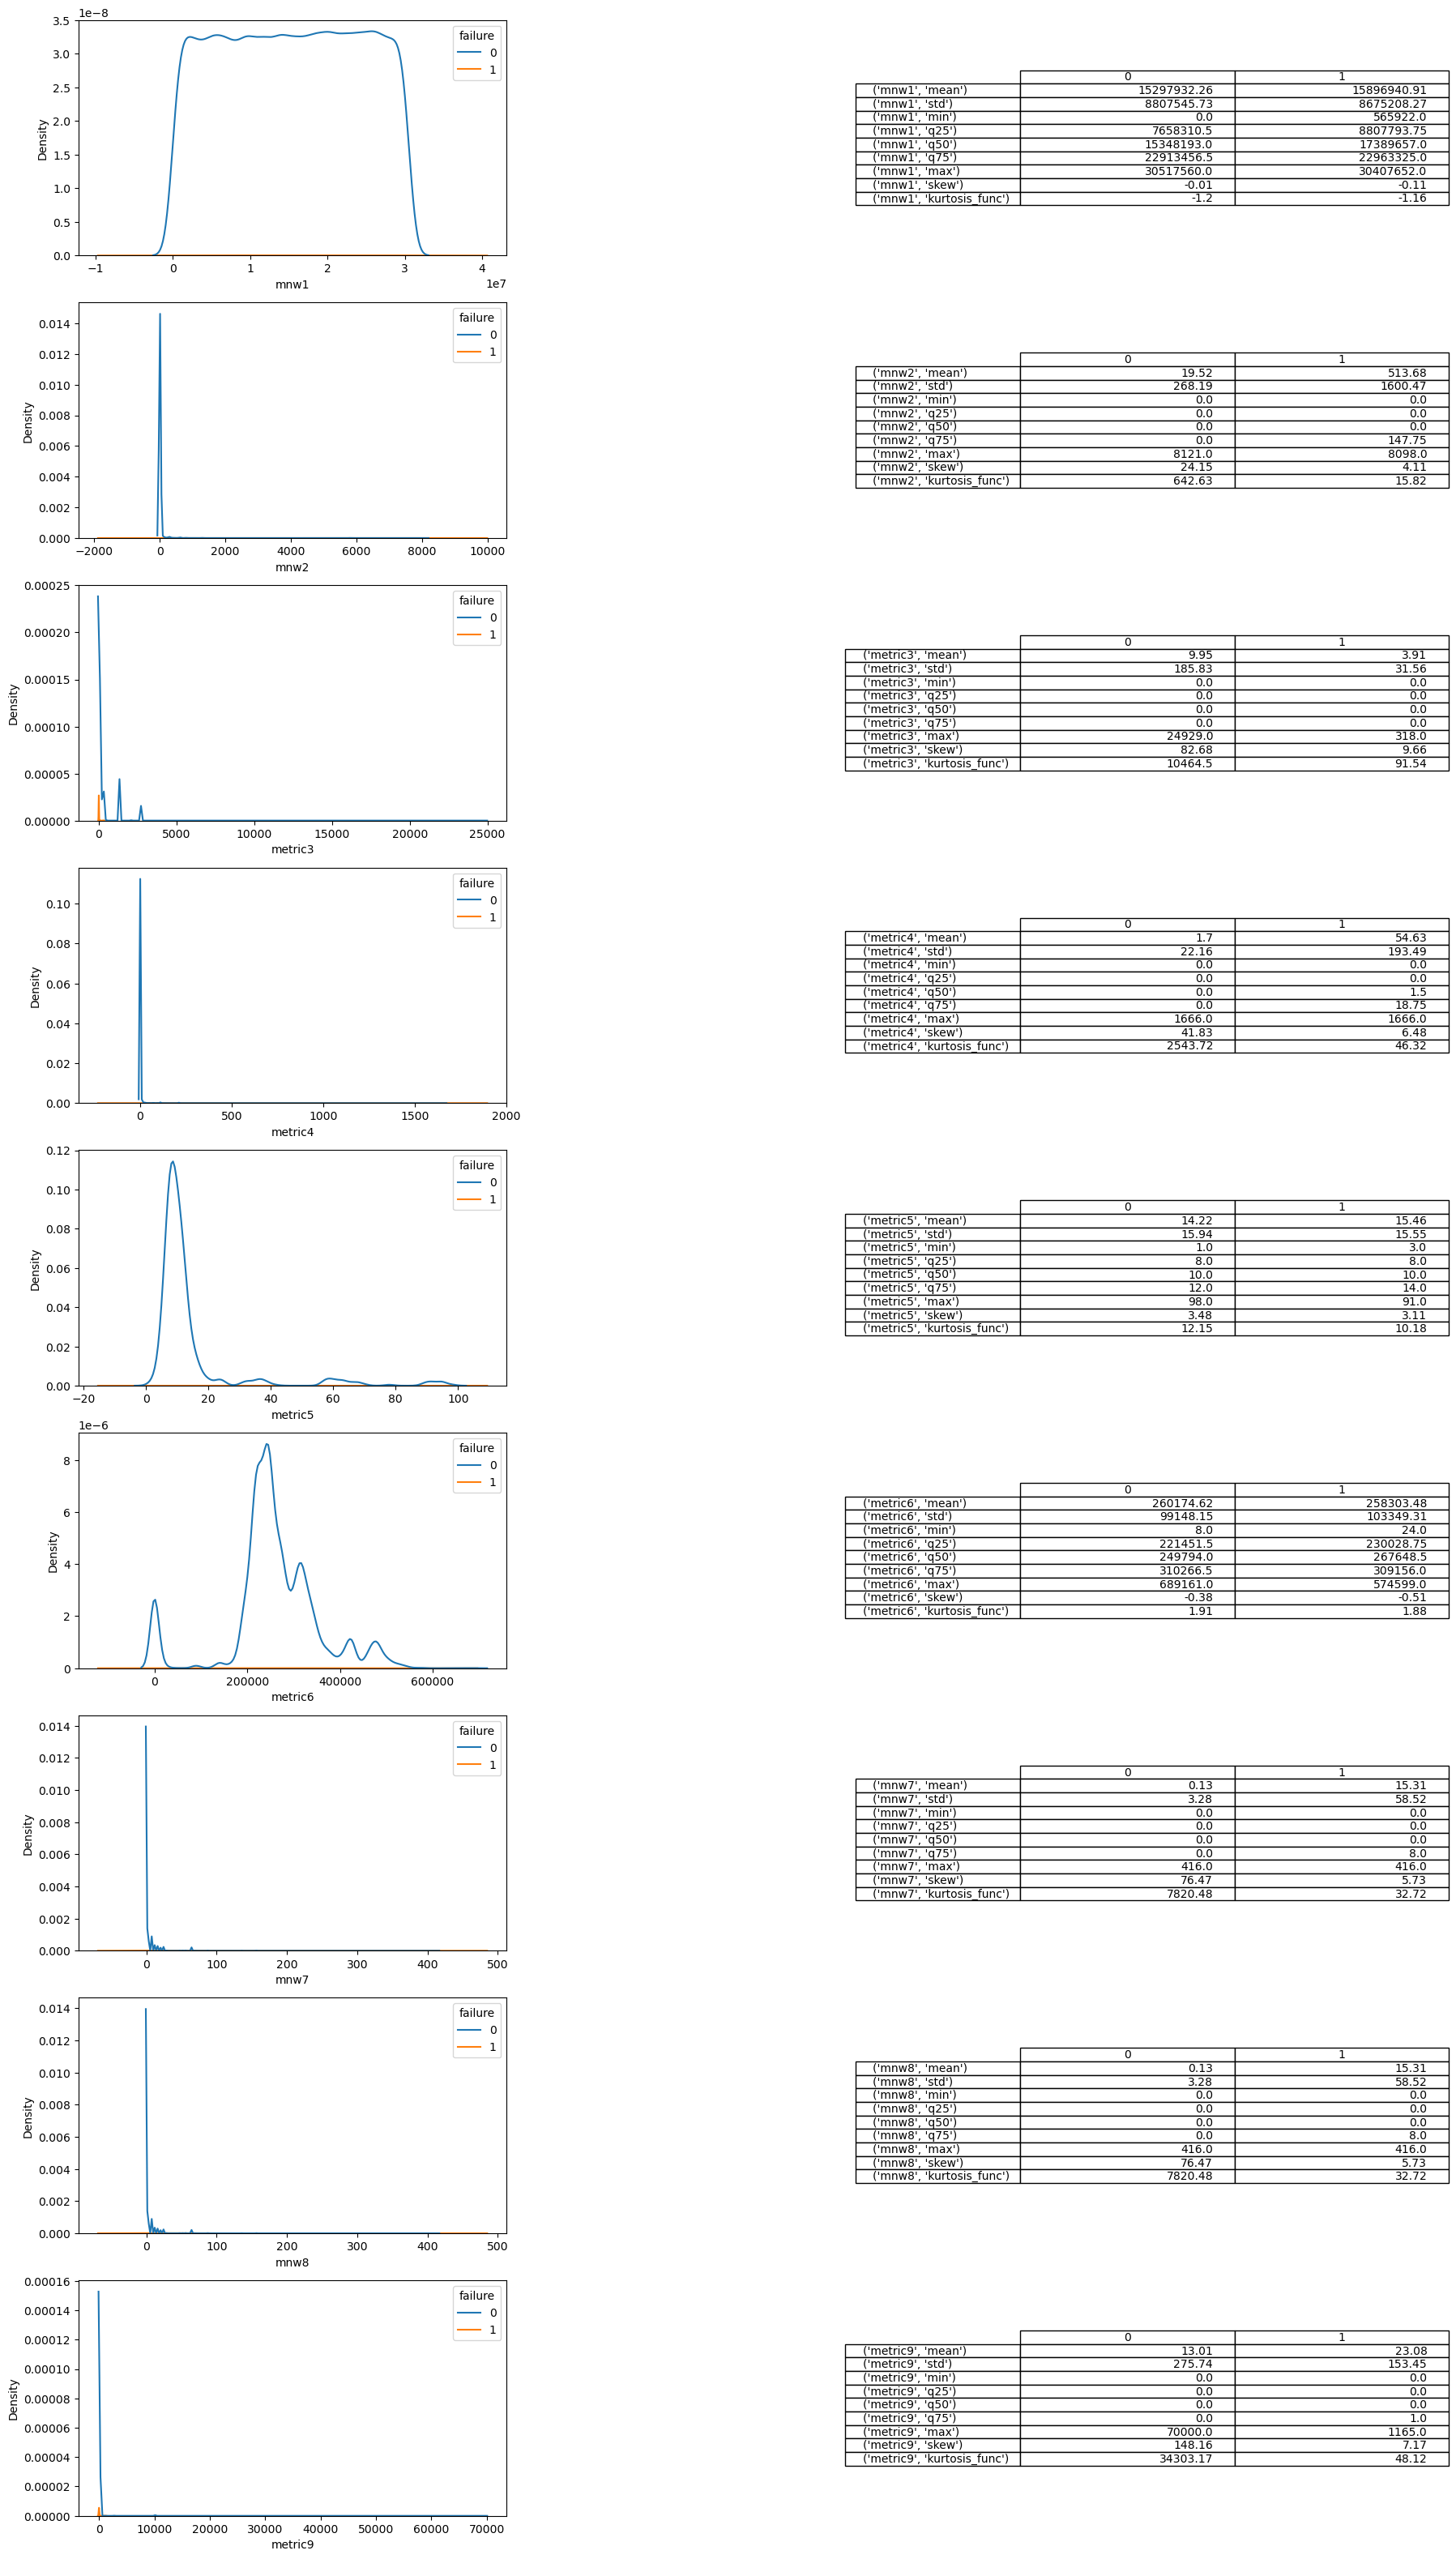

In [40]:
metrics = ['mnw1','mnw2','metric3', 'metric4', 'metric5', 'metric6', 'mnw7', 'mnw8','metric9']
figs, axs = plt.subplots(nrows = len(metrics),ncols = 2,figsize=(15,40))

for i in range(0,len(metrics)):
    agg_functions = {metrics[i]:['mean','std','min',q25,q50,q75,'max','skew',kurtosis_func]}
    #sns.histplot(data = df, x = metrics[i], bins = 30, ax = axs[i,0])
    aux = df.groupby(['failure']).agg(agg_functions).T.round(2)
    #aux = pd.DataFrame(df[metrics[i]].describe().round(2)) 
    
    sns.kdeplot(data = df, x = metrics[i],hue = 'failure', ax = axs[i,0])
    #sns.boxplot(data = df, y = metrics[i], ax = axs[i,1])
    
    axs[i,1].table(cellText= aux.values, colLabels=aux.columns, rowLabels= aux.index, loc = 'right')
    axs[i,1].axis("off")
    

Analisando os gráficos acima temos que:
- Apesar da variável 'mnw1' possuir valores elevados, eles são bem distribuidos.
- As variáveis 'mnw2','metric3', 'metric4', 'mnw7','mnw8' e 'metric9' possuem uma concentração de dados maior em torno do valor 0 e uma pequena quantidade de dados em valores elevados, possuindo uma skewness elevada.
- As variáveis 'metric5' e 'metric6' apresentam pequenas concentrações em valores distintos e espaçados.
- Nenhuma das variáveis apresentou uma diferença significativa entre as classes 0 e 1 de 'failure'.


Com base nesses insights será feita as seguintes manipulações:
- Como as variáveis 'metric5' e 'metric6' apresentam concentrações ditintas elas podem servir como uma medição contínua de uma característica do equipamento. portanto será criado uma variável auxiliar que representa a diferença entre o valor inicial da metrica com o seu valor ao longo dos dias para o dispositivo analisado.
- Como as variáveis 'mnw2','metric3', 'metric4', 'mnw7','mnw8' e 'metric9' possuem uma skewness elevada, será criado uma nova variável em formato logarítmico delas. 

In [41]:
df['dif_m6'] = df['metric6']
df['dif_m5'] = df['metric5']

df['log_m2'] = np.log(df['mnw2']+1)
df['log_m3'] = np.log(df['metric3']+1)
df['log_m4'] = np.log(df['metric4']+1)
df['log_m7'] = np.log(df['mnw7']+1)
df['log_m8'] = np.log(df['mnw8']+1)
df['log_m9'] = np.log(df['metric9']+1)

df.drop(['mnw2','metric3','metric4','mnw7','mnw8','metric9'], axis = 1, inplace = True)
dev_name = df['device'].unique()

for i in dev_name:
    filt = df[df['device'] == i]
    df.loc[filt.index,'dif_m6'] = filt['dif_m6'] - filt['metric6'].min()
    df.loc[filt.index,'dif_m5'] = filt['dif_m5'] - filt['metric5'].min()

<AxesSubplot:xlabel='dif_m6', ylabel='Count'>

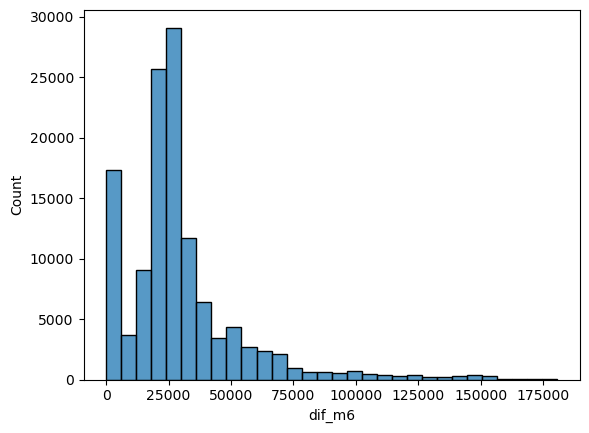

In [42]:
sns.histplot(data = df, x ='dif_m6', bins = 30)

<AxesSubplot:xlabel='dif_m5', ylabel='Count'>

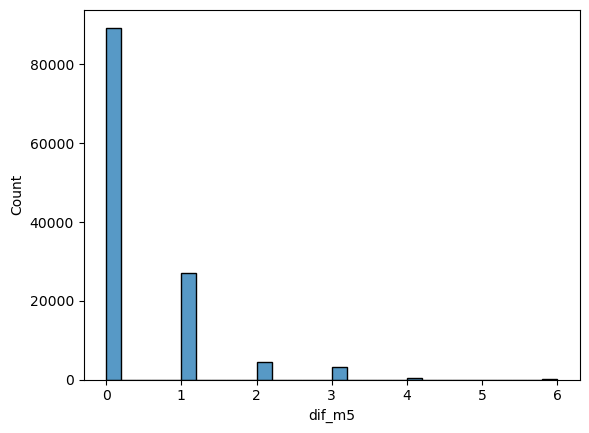

In [43]:
sns.histplot(data = df, x ='dif_m5', bins = 30)

Obseva-se que tanto para a métrica 'dif_m5' quanto para a 'dif_m6' não ocorre a presença de valores negativos, indicando que as variáveis 'metric5' e 'metric6' são variáveis contínuas crescentes. 

# Correlação

Visando evitar possíveis problemas de multicolinearidade na resolução do problema será utilizado o método de correlação de Pearson, visando identificar a correlação linear entre as variáveis.

Como valor de corte será utilizado o valor de 0.75 e de -0.75, sendo esses valores definidos empiricamente em projetos anteriores.


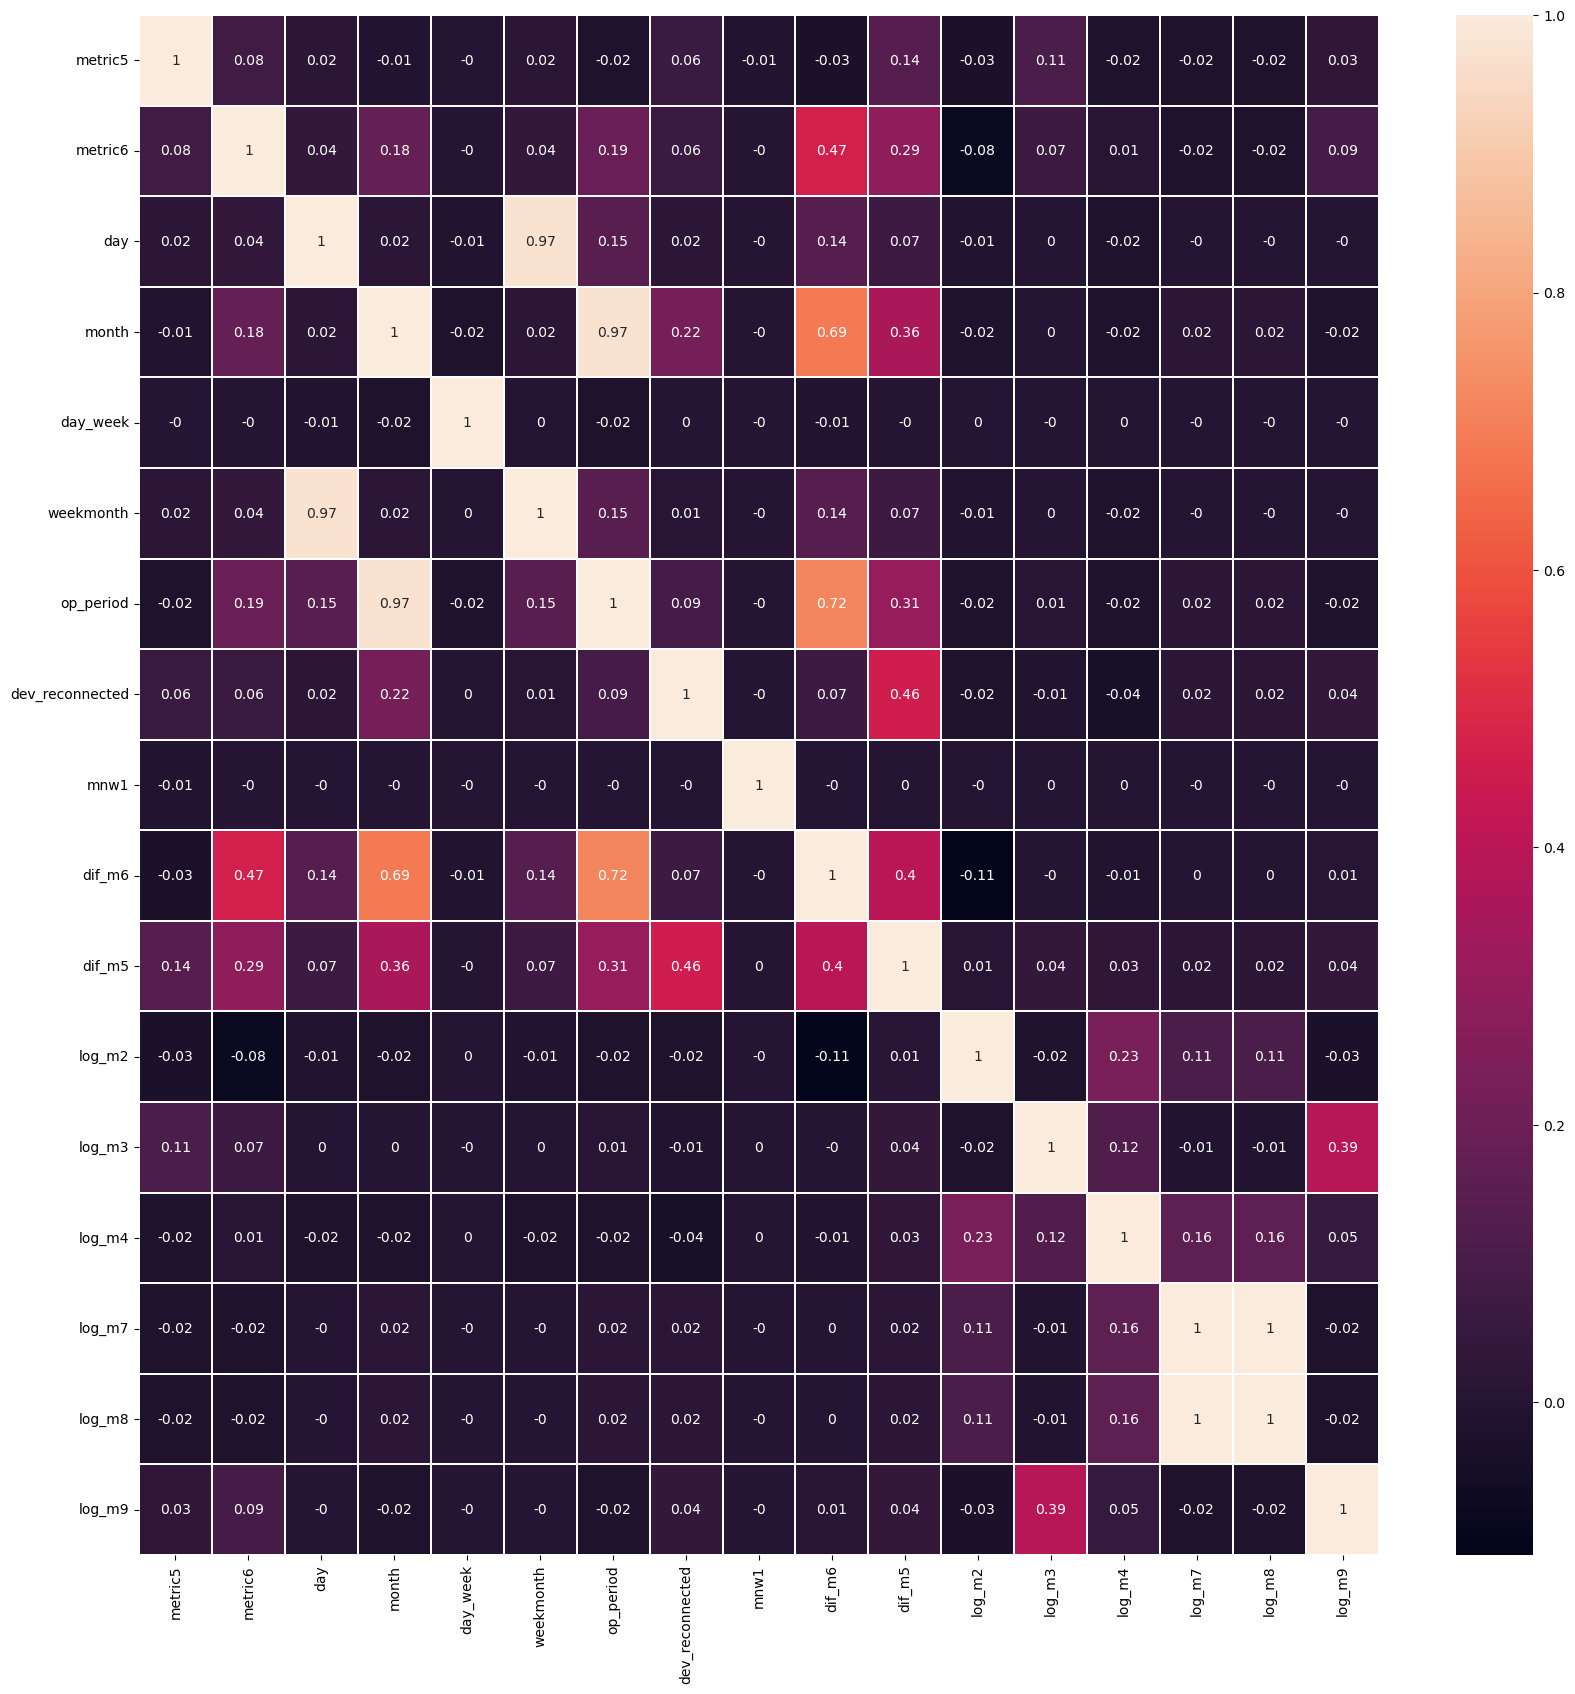

In [44]:
df_cod = df.drop(['failure','equipment','device','date','year'],axis =1)

fig, axes = plt.subplots(1, figsize=(20,20))
kendall_matrix = np.round(df_cod.corr(method='spearman'),2)
fig = sns.heatmap(kendall_matrix, annot=True,linewidths=.1)

Como as features 'log_m7' e 'log_m8' possuem correlação de 1, portanto a 'log_m8' será removida.

A feature 'weekmonth' possui alta correlação com a feature 'day', portanto ela será removida.

Como a feature 'month' possui alta correlação com a feature 'op_period', será feito a remoção de 'month'

Como visto anteriormente os dados foram coletados em um mesmo ano, logo a feature 'year' será removida.

Como a feature 'device' foi separada em 'sector' e 'equipment' ela será removida.

Como a feature 'equipment' representa um ID único do equipamento, em muitos casos ele pode enviesar muito o modelo, portanto ele será removido.

In [45]:
df_final = df.drop(['device','log_m8','weekmonth','year','equipment','date','month'],axis =1)

# Aplicação do modelo

Para o desenvolvimento do modelo será elaborado uma **'Rede Neural Direta (FNN)'** levando em consideração a métrica **'recall'** para a verificação de desempenho do modelo. Também será realizado o tunning dos hiperparâmetros do modelo com base no pacote **'OPTUNA'** para otimizar o seu desempenho.

## Treinamento do modelo

Para o treinamento do algoritmo o dataset inicialmente será dividido em um dataset de treino e um dataset de teste. Após isso será aplicado a técnica de 'cross-validation' para 10 folds visando um algoritmo final mais generalizado. 

Como existe um desbalanceamento das classes será aplicado o **'StratifiedKFold'**, que tem como objetivo a separação dos folds levando em consideração a proporção de cada variável, ou seja, se a classe minoritária existir em 1% do dataset, ele irá dividir esse 1% em X partes iguais e unirá com os outros 99% divididos também em X partes.
    
Durante o treinamento do algoritmo será realizado o método de **upsample** da classe minoritária por meio do pacote **SMOTE**, tornando a classe minoritária com a mesma quantidade da classe majoritária.
   
Para a variável categórica 'sector' será aplicado o **'OneHotEncoder'**, dividindo os setores em novas colunas.

Após isso será aplicado o **'StandardScaler'** nas variáveis para melhorar o desempenho e precisão do modelo.


In [46]:
X = df_final.drop(['failure'], axis = 1)
y = df_final['failure']
X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state = 0, test_size=0.4, shuffle = True)
X_train.reset_index(inplace = True, drop = True)
Y_train.reset_index(inplace = True, drop = True)

X_test.reset_index(inplace = True, drop = True)
Y_test.reset_index(inplace = True, drop = True)

In [47]:
def preprocess(X,Y,OHE,low_card,scaler,i,sm):
    x = X.copy()
    y = Y.copy()
    
    x.reset_index(inplace = True, drop = True)
    y.reset_index(inplace = True, drop = True)
    
    if i == 1:
        # codificando as variáveis categóricas
        coding_hot = OHE.fit_transform(x[low_card].to_numpy())
        aux = pd.DataFrame(coding_hot, columns = OHE.get_feature_names_out(low_card))
        x = pd.concat([x, aux], axis=1).drop(low_card, axis=1)
        # Escalonando as features
        aux = scaler.fit_transform(x)
        x = pd.DataFrame(aux,index=x.index, columns=x.columns)
        xf, yf = sm.fit_resample(x, y) 
        
    else:
        # codificando as variáveis categóricas
        coding_hot = OHE.transform(x[low_card].to_numpy())
        aux = pd.DataFrame(coding_hot, columns = OHE.get_feature_names_out(low_card))
        x = pd.concat([x, aux], axis=1).drop(low_card, axis=1)
        # Escalonando as features
        aux2 = scaler.transform(x)
        xf = pd.DataFrame(aux2,index=x.index, columns=x.columns)
        yf = y
    
    return xf, yf

In [70]:
def model_FNN(trial):
    
    model = Sequential()
    
    n_layers = trial.suggest_int("n_layers", 1, 3)
    initial_hidden = trial.suggest_int("n_units_initial", 4, 128, log=True)
    
    model.add(Dense(initial_hidden,input_dim = (21), activation = 'relu'))
    dropout_initial = trial.suggest_float("dropout_initial", 0.2, 0.7,step =0.1)
    model.add(Dropout(rate=dropout_initial))
    
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True)
        activ = trial.suggest_categorical("actvation_func_l{}".format(i),['relu','tanh'])
        
        model.add(Dense(num_hidden, activation=activ))
        dropout = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.7,step =0.1)
        model.add(Dropout(rate=dropout))
        
    model.add(Dense(1, activation='sigmoid'))
    
    lr = trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True)    
    metric = keras.metrics.Recall()
    #metric = keras.metrics.F1Score()

    
    model.compile(loss ='binary_crossentropy', optimizer = Adam(learning_rate=lr), metrics = [metric])
    
    return model

In [71]:
def Objective1(trial):
    # Clear clutter from previous session graphs.
    keras.backend.clear_session()
    
        
    # Generate our trial model.
    
    
    metric_skf = []
    for i, (train_i, val_i) in enumerate(skf.split(X_train, Y_train)):    
        x_tr , x_vr = X_train.loc[train_i], X_train.loc[val_i]
        y_tr , y_vr = Y_train[train_i], Y_train[val_i]

        OHE =  OneHotEncoder(handle_unknown = 'ignore',sparse=False)
        scaler = StandardScaler()
        sm = SMOTE(random_state=0)
        low_card =['sector']

        x_res, y_res = preprocess(x_tr, y_tr,OHE,low_card,scaler,1,sm)   
        x_v, y_v = preprocess(x_vr, y_vr,OHE,low_card,scaler,0,sm)
        
        
        model = model_FNN(trial)
        
        BATCHSIZE = trial.suggest_int("batch_size",200,3000,100)
        EPOCHS = trial.suggest_int("epoch",2,30)
        model.fit(x_res,tf.cast(y_res, tf.float32), batch_size=BATCHSIZE, epochs=EPOCHS, verbose = 0)
        
        predicted = model.predict(x_v, verbose = 0)   
        y_pred = np.array([1 if x >= 0.5 else 0 for x in predicted])
        
        
        metric_skf.append(round(recall_score(y_v,y_pred),4))
        #metric_skf.append(round(f1_score(y_v,y_pred),4))

    return round(np.mean(metric_skf),4)*100

In [72]:
tf.random.set_seed(221)
skf = StratifiedKFold(n_splits=5)
study = optuna.create_study(direction = 'maximize')
study.optimize(Objective1, n_trials = 30, show_progress_bar = True)

[I 2023-12-17 18:52:19,350] A new study created in memory with name: no-name-4b0d53aa-bee9-4001-93c2-8f5cae3f346a
C:\Users\Pichau\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-12-17 18:53:25,922] Trial 0 finished with value: 26.57 and parameters: {'n_layers': 3, 'n_units_initial': 86, 'dropout_initial': 0.7, 'n_units_l0': 125, 'actvation_func_l0': 'relu', 'dropout_l0': 0.7, 'n_units_l1': 6, 'actvation_func_l1': 'tanh', 'dropout_l1': 0.30000000000000004, 'n_units_l2': 98, 'actvation_func_l2': 'relu', 'dropout_l2': 0.2, 'learning_rate': 0.0007528416654381212, 'batch_size': 2400, 'epoch': 17}. Best is trial 0 with value: 26.57.
[I 2023-12-17 18:53:46,285] Trial 1 finished with value: 73.14 and parameters: {'n_layers': 2, 'n_units_initial': 10, 'dropout_initial': 0.6000000000000001, 'n_units_l0': 58, 'actvation_func_l0': 'tanh', 'dropout_l0': 0.2, 'n_units_l1': 96, 'actvation_func_l1': 'tanh', 'dropout_l1': 0.6000000000000001, 'learning_rate': 1.9981444982076405e-05, 'batch_size': 2500, 'epoch': 9}. Best is trial 1 with value: 73.14.
[I 2023-12-17 18:54:18,011] Trial 2 finished with value: 74.57000000000001 and parameters: {'n_layers': 3, 'n_units_initia

[I 2023-12-17 19:04:57,021] Trial 20 finished with value: 71.72 and parameters: {'n_layers': 2, 'n_units_initial': 14, 'dropout_initial': 0.30000000000000004, 'n_units_l0': 12, 'actvation_func_l0': 'relu', 'dropout_l0': 0.30000000000000004, 'n_units_l1': 21, 'actvation_func_l1': 'relu', 'dropout_l1': 0.30000000000000004, 'learning_rate': 6.60899796199792e-05, 'batch_size': 3000, 'epoch': 30}. Best is trial 13 with value: 78.57.
[I 2023-12-17 19:05:27,610] Trial 21 finished with value: 66.47999999999999 and parameters: {'n_layers': 2, 'n_units_initial': 6, 'dropout_initial': 0.6000000000000001, 'n_units_l0': 116, 'actvation_func_l0': 'tanh', 'dropout_l0': 0.2, 'n_units_l1': 126, 'actvation_func_l1': 'tanh', 'dropout_l1': 0.6000000000000001, 'learning_rate': 9.937693796086281e-06, 'batch_size': 2400, 'epoch': 7}. Best is trial 13 with value: 78.57.
[I 2023-12-17 19:05:46,480] Trial 22 finished with value: 40.760000000000005 and parameters: {'n_layers': 2, 'n_units_initial': 8, 'dropout_i

In [73]:
plot_optimization_history(study)

Nota-se pelo gráfico do histórico do tunning do modelo que ocorreu uma melhora na performance do modelo com o decorrer das iterações, obtendo um **'recall'** médio de 80.38% na validação cruzada.

In [74]:
plot_slice(study)

In [75]:
plot_param_importances(study)

Observando o gráfico de importância dos hiperparâmetros, os que tiveram mais impacto no modelo é a quantidade de épocas no treinamento, o valor do learning rate e a números de neurônios da camada inicial.

In [76]:
study.best_params

{'n_layers': 3,
 'n_units_initial': 89,
 'dropout_initial': 0.7,
 'n_units_l0': 5,
 'actvation_func_l0': 'relu',
 'dropout_l0': 0.5,
 'n_units_l1': 6,
 'actvation_func_l1': 'relu',
 'dropout_l1': 0.4,
 'n_units_l2': 10,
 'actvation_func_l2': 'tanh',
 'dropout_l2': 0.5,
 'learning_rate': 4.640103294479055e-05,
 'batch_size': 1900,
 'epoch': 21}

In [97]:
keras.backend.clear_session()
model_final = Sequential()

model_final.add(Dense(89,input_dim = 21, activation = 'relu')) # initial
model_final.add(Dropout(rate=0.7))

model_final.add(Dense(5, activation = 'relu')) # 0
model_final.add(Dropout(rate=0.5))
model_final.add(Dense(6, activation = 'relu')) # 1
model_final.add(Dropout(rate=0.4))
model_final.add(Dense(10, activation = 'tanh')) # 2
model_final.add(Dropout(rate=0.5))

model_final.add(Dense(1, activation='sigmoid'))

lr =    4.640103294479055e-05
metric = keras.metrics.Recall()

model_final.compile(loss ='binary_crossentropy', optimizer = Adam(learning_rate=lr), metrics = [metric])
BATCHSIZE = 1900
EPOCHS = 21

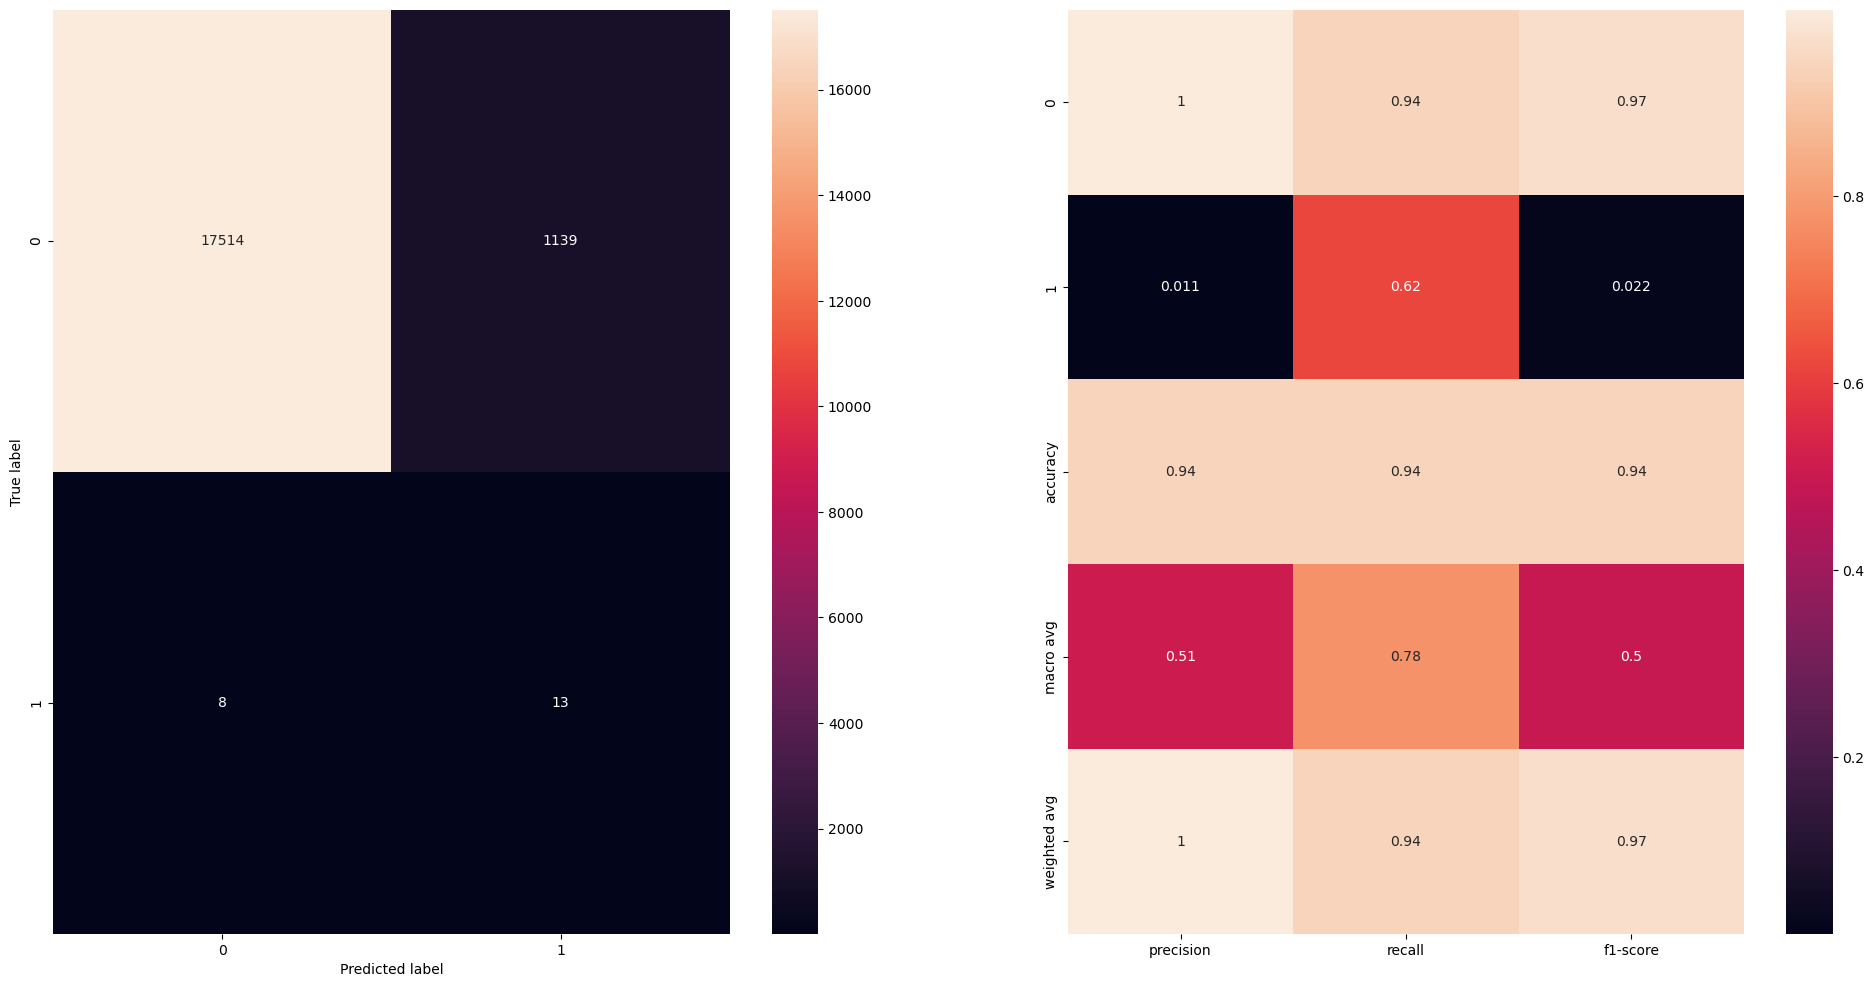

In [98]:
##############################
low_card =['sector']
OHE =  OneHotEncoder(handle_unknown = 'ignore',sparse=False)
scaler = StandardScaler()
sm = SMOTE(random_state=0)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, random_state = 0, test_size=0.25)

X_res, Y_res = preprocess(x_train, y_train,OHE,low_card,scaler,1,sm)   
X_val, Y_val = preprocess(x_val, y_val,OHE,low_card,scaler,0,sm)

model_final.fit(X_res,Y_res, batch_size=BATCHSIZE, epochs=EPOCHS, verbose = 0)

#############################

predicted = model_final.predict(X_val, verbose = 0) 
y_pred = np.array([1 if x >= 0.5 else 0 for x in predicted])

cf_matrix = confusion_matrix(Y_val, y_pred)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,12))
sns.heatmap(cf_matrix, annot=True,fmt='.0f', ax = ax1).set(xlabel='Predicted label', ylabel='True label')

report=classification_report(Y_val,y_pred, output_dict=True)
rep = pd.DataFrame(report)

sns.heatmap(rep.iloc[:-1, :].T, annot=True, ax = ax2)

plt.show()

Treinando novamente o modelo sem a validação cruzada, temos um resuldado com um recall de aproximadamente 62%, porém um valor de precisão próximo de 1%.

Nota-se que a quantidade de Falsos Positivos é equivalente a aproximadamente 10% da quantidade de Verdadeiros Positivos, que na prática em uma situação de manutenção, não seriam paradas/verificações muito recorrentes para garantir a confiabilidade e a seguraça do equipamento.

## Avaliando o dataset de teste

1557/1557 [==============================] - 1s 601us/step


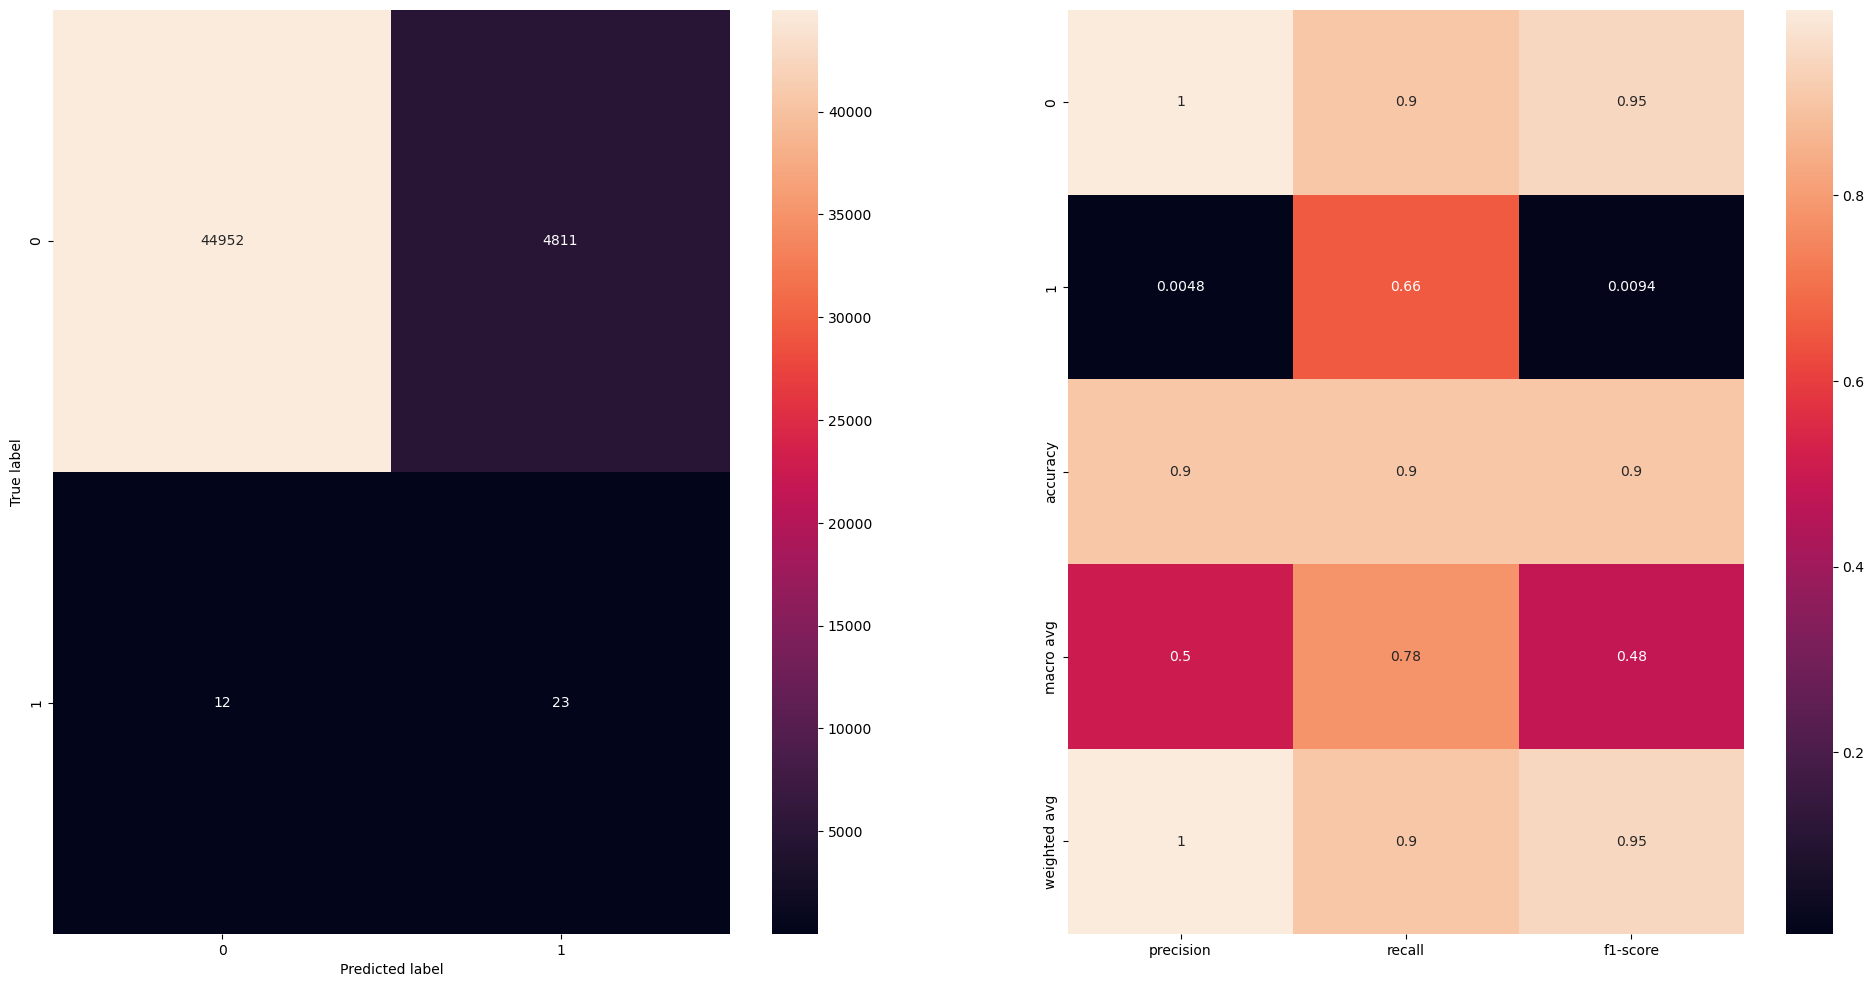

In [99]:
low_card =['sector']
OHE =  OneHotEncoder(handle_unknown = 'ignore',sparse=False)
scaler = StandardScaler()
sm = SMOTE(random_state=0)

X_1, Y_1 = preprocess(X_train, Y_train,OHE,low_card,scaler,1,sm)   
X_t, Y_t = preprocess(X_test, Y_test,OHE,low_card,scaler,0,sm)
#-------------------------------------------------------------------------------------------------------------
keras.backend.clear_session()
model_final = Sequential()

model_final.add(Dense(89,input_dim = 21, activation = 'relu')) # initial
model_final.add(Dropout(rate=0.7))

model_final.add(Dense(5, activation = 'relu')) # 0
model_final.add(Dropout(rate=0.5))
model_final.add(Dense(6, activation = 'relu')) # 1
model_final.add(Dropout(rate=0.4))
model_final.add(Dense(10, activation = 'tanh')) # 2
model_final.add(Dropout(rate=0.5))

model_final.add(Dense(1, activation='sigmoid'))

lr =    4.640103294479055e-05
metric = keras.metrics.Recall()

model_final.compile(loss ='binary_crossentropy', optimizer = Adam(learning_rate=lr), metrics = [metric])
BATCHSIZE = 1900
EPOCHS = 21

model_final.fit(X_1,Y_1, batch_size=BATCHSIZE, epochs=EPOCHS, verbose = 0)

#--------------------------------------------------------------------------------------------------------------
# predict results
predicted = model_final.predict(X_t) 
y_pred = np.array([1 if x >= 0.5 else 0 for x in predicted])

cf_matrix = confusion_matrix(Y_t, y_pred)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,12))

sns.heatmap(cf_matrix, annot=True,fmt='.0f', ax = ax1).set(xlabel='Predicted label', ylabel='True label')

report=classification_report(Y_t,y_pred, output_dict=True)
rep = pd.DataFrame(report)

sns.heatmap(rep.iloc[:-1, :].T, annot=True, ax = ax2)

plt.show()

Aplicando o modelo para o dados de teste, obtivemos um resultado similar aos dados de treino.

# **Conclusão**

O resultado alcançado no modelo final foi aceitável possuindo um recall aproximado de 0.66, porém obteve um valor abaixo para a precisão.

A fim de melhorar o projeto em trabalhos futuros, as seguintes atividades podem ser realizadas:
- Aplicação de um modelo de clusterização para a criação de novas features, visando incrementar a capacidade preditiva do modelo.
- Teste de outros modelos de aprendizado de máquina, tentando aperfeiçoar o recall.
- Avaliação de importância das features na entrada do modelo, visando a remoção das features que possuem pouca capacidade preditiva.
